In [ ]:
# import package
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

# import data
df_ori = pd.read_csv("hasilpreproses.csv")
df_ori = df_ori.filter(['content'])
df = pd.read_csv("hasilpreproses.csv")
df = df.filter(['content_preprocessing'])

# Convert to list
data = df['content_preprocessing'].values.tolist()

def sent_to_words(sentences):
    for sentence in sentences:
        yield gensim.utils.simple_preprocess(str(sentence), deacc=True)

data_words = list(sent_to_words(data))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=50, threshold=1)  # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

# Define functions bigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 98.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 35.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicor

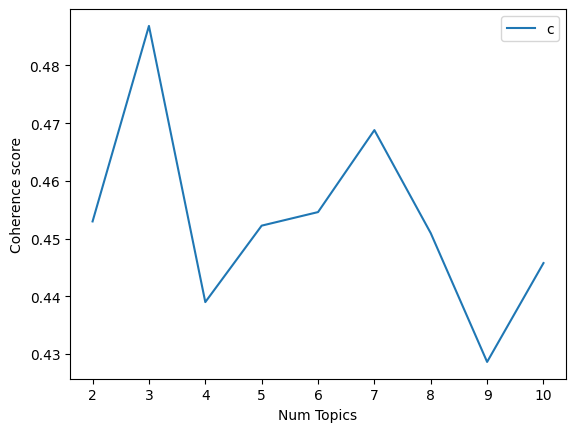

Num Topics = 2  has Coherence Value of 0.453
Num Topics = 3  has Coherence Value of 0.487
Num Topics = 4  has Coherence Value of 0.439
Num Topics = 5  has Coherence Value of 0.452
Num Topics = 6  has Coherence Value of 0.455
Num Topics = 7  has Coherence Value of 0.469
Num Topics = 8  has Coherence Value of 0.451
Num Topics = 9  has Coherence Value of 0.429
Num Topics = 10  has Coherence Value of 0.446


In [ ]:
# import package
!pip install pyLDAvis
import gensim
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# function to compute coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Show graph
limit = 11
start = 2
step = 1
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 3))

In [ ]:
# import package
from pprint import pprint

# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=15))

# melabeli data berdasarkan keywords
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break

    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)

    return sent_topics_df

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# melihat sentimen dari text original
cek_df = pd.DataFrame([])
cek_df = df_dominant_topic.copy()
cek_df['Content'] = df_ori['content'].copy()
cek_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-4-dbabc3bc3f2a>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
<ipython-input-4-dbabc3bc3f2a>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
<ipython-input-4-dbabc3bc3f2a>:23: FutureWarning: The f

[(0,
  '0.021*"tugas" + 0.018*"aplikasi" + 0.013*"baik" + 0.011*"edlink" + '
  '0.010*"mau" + 0.010*"nya" + 0.010*"dosen" + 0.010*"lama" + 0.009*"jadi" + '
  '0.008*"bagus" + 0.007*"malah" + 0.007*"buat" + 0.007*"padahal" + '
  '0.007*"update" + 0.007*"mudah"'),
 (1,
  '0.018*"edlink" + 0.017*"aplikasi" + 0.013*"masuk" + 0.013*"buka" + '
  '0.012*"padahal" + 0.011*"baik" + 0.011*"ajar" + 0.011*"nya" + 0.010*"baru" '
  '+ 0.009*"gak" + 0.008*"udah" + 0.008*"susah" + 0.008*"update" + '
  '0.008*"tugas" + 0.007*"mohon"'),
 (2,
  '0.029*"aplikasi" + 0.026*"edlink" + 0.016*"nya" + 0.014*"kuliah" + '
  '0.013*"bagus" + 0.012*"tugas" + 0.012*"sangat" + 0.011*"jadi" + '
  '0.011*"update" + 0.011*"baik" + 0.010*"buka" + 0.009*"mudah" + 0.008*"ga" + '
  '0.008*"terus" + 0.007*"guna"')]


<ipython-input-4-dbabc3bc3f2a>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
<ipython-input-4-dbabc3bc3f2a>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
<ipython-input-4-dbabc3bc3f2a>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
<ipython-input-4-dbabc3bc3f2a>:23: FutureWarning: The frame.append method is deprecated and will be removed from pa

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Content
0,0,0,0.9253,"tugas, aplikasi, baik, edlink, mau, nya, dosen...","['bagaimana', 'atas', 'simpang', 'full', 'hapu...",Bagaimana mengatasi penyimpangan yang sudah fu...
1,1,2,0.9081,"aplikasi, edlink, nya, kuliah, bagus, tugas, s...","['aplikasi', 'bagus', 'sekali', 'bantu', 'maha...",Aplikasinya bagus sekali Bisa membantu mahasis...
2,2,2,0.7599,"aplikasi, edlink, nya, kuliah, bagus, tugas, s...","['sangat', 'bagus']",Sangat bagus
3,3,0,0.6575,"tugas, aplikasi, baik, edlink, mau, nya, dosen...",['good'],Good
4,4,2,0.8743,"aplikasi, edlink, nya, kuliah, bagus, tugas, s...","['banyak', 'tab', 'bug', 'rapihkan', 'terimaka...",Masih banyak tab yang bug tolong di rapihkan k...


In [ ]:
import pandas as pd

# Fungsi untuk melabeli topik
def label_topics(row):
    if row['Dominant_Topic'] == 0:
        return 'Application  Usability '  # Ganti dengan label aspek yang sesuai
    elif row['Dominant_Topic'] == 1:
        return 'Application Reliability '  # Ganti dengan label aspek yang sesuai
    elif row['Dominant_Topic'] == 2:
        return 'Applicaton Performance Efficiency  '  # Ganti dengan label aspek yang sesuai
    else:
        return 'Unknown'

# Memanggil fungsi untuk melabeli topik
df_dominant_topic['Topic_Label'] = df_dominant_topic.apply(label_topics, axis=1)

# Load dataset hasilpreproses.csv
df_preprocessed = pd.read_csv('hasilpreproses.csv')

# Menambahkan kolom sentimen dari kolom polarity
df_dominant_topic['Sentimen'] = df_preprocessed['polarity']

# Melihat hasil
cek_df = df_dominant_topic.copy()
cek_df['Content'] = df_ori['content'].copy()

cek_df.head()



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Topic_Label,Sentimen,Content
0,0,2,0.9187,"edlink, baik, aplikasi, masuk, ajar, kuliah, t...","['bagaimana', 'atas', 'simpang', 'full', 'hapu...",Applicaton Performance Efficiency,negative,Bagaimana mengatasi penyimpangan yang sudah fu...
1,1,1,0.8988,"aplikasi, bagus, nya, update, buka, tugas, ser...","['aplikasi', 'bagus', 'sekali', 'bantu', 'maha...",Application Reliability,negative,Aplikasinya bagus sekali Bisa membantu mahasis...
2,2,1,0.7339,"aplikasi, bagus, nya, update, buka, tugas, ser...","['sangat', 'bagus']",Application Reliability,negative,Sangat bagus
3,3,1,0.6542,"aplikasi, bagus, nya, update, buka, tugas, ser...",['good'],Application Reliability,positive,Good
4,4,2,0.8643,"edlink, baik, aplikasi, masuk, ajar, kuliah, t...","['banyak', 'tab', 'bug', 'rapihkan', 'terimaka...",Applicaton Performance Efficiency,positive,Masih banyak tab yang bug tolong di rapihkan k...


In [ ]:
df_dominant_topic.to_csv('hasil_TOPIC & SENTIMEN.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
